In [1]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

In [3]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

In [4]:
#Parametros para filtragem dos dados

contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

tipo_contratacao = 'Empresarial'

porte_operadora = 'Médio'

tipo_modalidade = 'Filantropia'

## Leitura dos dados

In [5]:
path = f'D:/TCC/TCC/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv'

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')  #Leitura da base

ans['ano'] = ans['ano'].astype('str')

ans['cd_ops'] = ans['cd_ops'].astype('str')

ans['lg_cancelada'] = ans['lg_cancelada'].astype('str')

ans['lg_nova_ops'] = ans['lg_nova_ops'].astype('str')

ans['ano'] = pd.PeriodIndex(ans['ano'], freq="Y")

ans['trimestre'] = pd.PeriodIndex(ans['trimestre'], freq="Q")

ans = ans[(ans.ano > '2017') & (ans.ano < '2022')]

ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

ans_filt = ans[(ans['lg_cancelada']!='1.0') & (ans['benef']!=np.nan)].reset_index(drop=True)

ans_filt.head()

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/03/2018,2018Q1,791860.200,0.000,722.000,0.0,0.0
1,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2018,2018Q2,769499.340,0.000,731.000,0.0,0.0
2,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2018,2018Q3,846654.020,0.000,774.000,0.0,0.0
3,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/12/2018,2018Q4,903017.550,0.000,787.000,0.0,0.0
4,2019,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2019,2019Q2,1801080.840,0.000,775.000,0.0,0.0


In [6]:
ans_filt_cont_mod = ans_filt[ (ans_filt['contratacao'] == tipo_contratacao) & 
                              (ans_filt['modalidade'] == tipo_modalidade) &
                              (ans_filt['port_ops'] == porte_operadora)].reset_index(drop=True)

ans_filt_cont_mod = ans_filt_cont_mod[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

ans_filt_cont_mod.head()


,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,trimestre,receita,despesa,benef
0,2018,318299,BENEFICENCIA CAMILIANA DO SUL,Filantropia,Médio,P,Empresarial,Pos-estabelecido,2018Q1,8749.910,2817.770,82.000
1,2018,318299,BENEFICENCIA CAMILIANA DO SUL,Filantropia,Médio,P,Empresarial,Pos-estabelecido,2018Q2,8796.650,2814.250,77.000
2,2018,318299,BENEFICENCIA CAMILIANA DO SUL,Filantropia,Médio,P,Empresarial,Pos-estabelecido,2018Q3,9711.190,2544.540,94.000
3,2018,318299,BENEFICENCIA CAMILIANA DO SUL,Filantropia,Médio,P,Empresarial,Pos-estabelecido,2018Q4,10615.790,3280.110,94.000
4,2019,318299,BENEFICENCIA CAMILIANA DO SUL,Filantropia,Médio,P,Empresarial,Pos-estabelecido,2019Q1,11025.440,4414.440,90.000


In [7]:
ans_filt_cont_mod.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),'despesa':lambda x: sum_million(x)}).head()

receita  despesa
ano  cd_ops razao_social                    trimestre                  
2018 318299 BENEFICENCIA CAMILIANA DO SUL   2018Q1      11.810    9.000
                                            2018Q2      12.010    9.810
                                            2018Q3      10.890    9.980
                                            2018Q4      11.620   10.200
     322326 ASSOCIAÇÃO BENEFICENTE CATÓLICA 2018Q1       1.380    0.070

In [8]:
ans_filt_cont_mod_agrup = ans_filt_cont_mod.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                             'despesa':lambda x: sum_million(x),
                                                                                             'benef': 'sum',
                                                                                             'cd_ops':lambda x: x.nunique()})

ans_filt_cont_mod_agrup['pct_despesa'] = ans_filt_cont_mod_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_cont_mod_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[(ans_filt_cont_mod_agrup.trimestre > '2017Q4') & (ans_filt_cont_mod_agrup.trimestre < '2022Q1')]

ans_filt_cont_mod_agrup[['n_ops','benef']] = ans_filt_cont_mod_agrup[['n_ops','benef']].astype('int')

#ans_filt_cont_mod_agrup['trimestre'] = pd.PeriodIndex(ans_filt_cont_mod_agrup['trimestre'], freq="Q")

ans_filt_cont_mod_agrup.set_index('trimestre', inplace=True)

ans_filt_cont_mod_agrup

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,86.870,70.410,228631,10,81.050
2018Q2,90.550,74.650,230336,10,82.440
2018Q3,92.030,77.400,231756,10,84.100
2018Q4,90.700,73.460,224314,9,80.990
2019Q1,89.630,72.360,225117,9,80.730
2019Q2,100.000,86.420,234792,10,86.420
2019Q3,101.850,87.640,238280,10,86.050
2019Q4,104.280,81.340,239596,10,78.000
2020Q1,112.140,76.080,241946,10,67.840


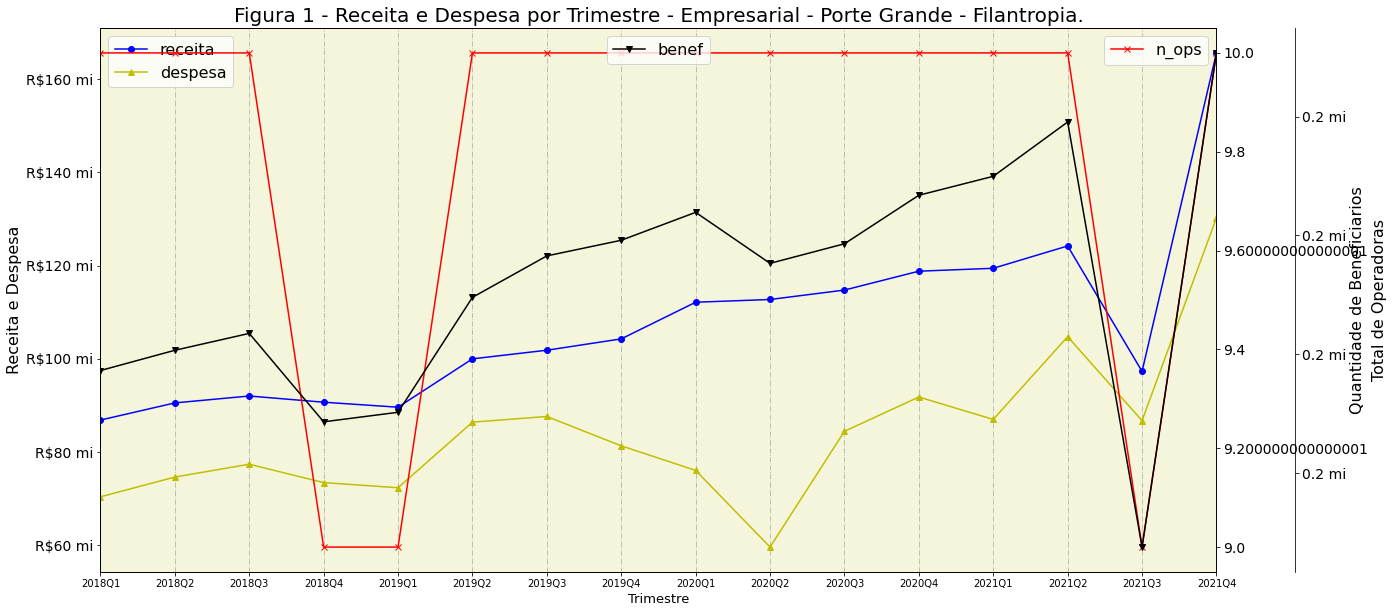

In [9]:
df_plot = ans_filt_cont_mod_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Empresarial - Porte Grande - Filantropia.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1000000) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [10]:
#Cria o rankin das operadoras com maior receita e despesa
ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                         'despesa':lambda x: sum_million(x),
                                                                                                         'benef': 'sum'}).reset_index(drop=True)

ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod_agrup_ops.sort_values(['benef'],ascending = False).groupby('trimestre').head(100).reset_index()

#ans_filt_ind_seg_agrup_ops.sort_values(by=['ano','benef'], ascending=[True,False], inplace=True)

ans_filt_cont_mod_agrup_ops.head()

,index,ano,cd_ops,trimestre,receita,despesa,benef
0,6,2018,322326,2018Q3,1.670,0.010,40789.000
1,5,2018,322326,2018Q2,1.640,0.050,40522.000
2,7,2018,322326,2018Q4,1.770,0.000,40371.000
3,45,2019,322326,2019Q3,1.610,0.440,40218.000
4,4,2018,322326,2018Q1,1.380,0.070,40164.000


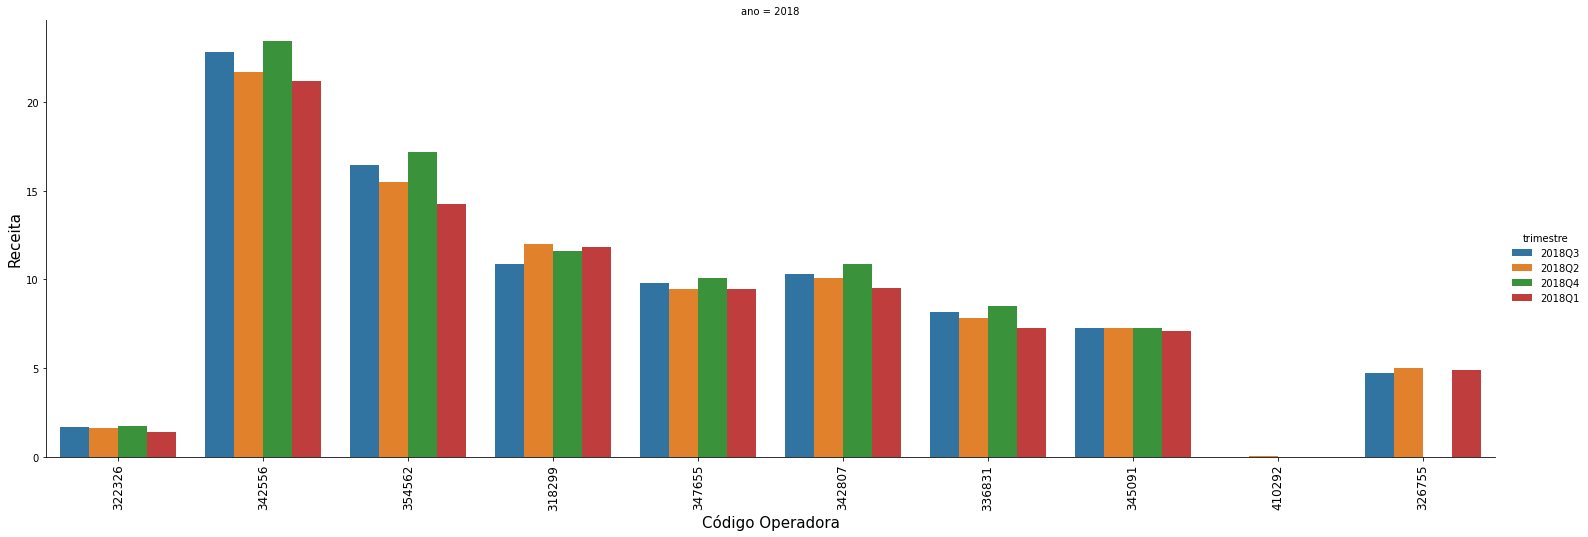

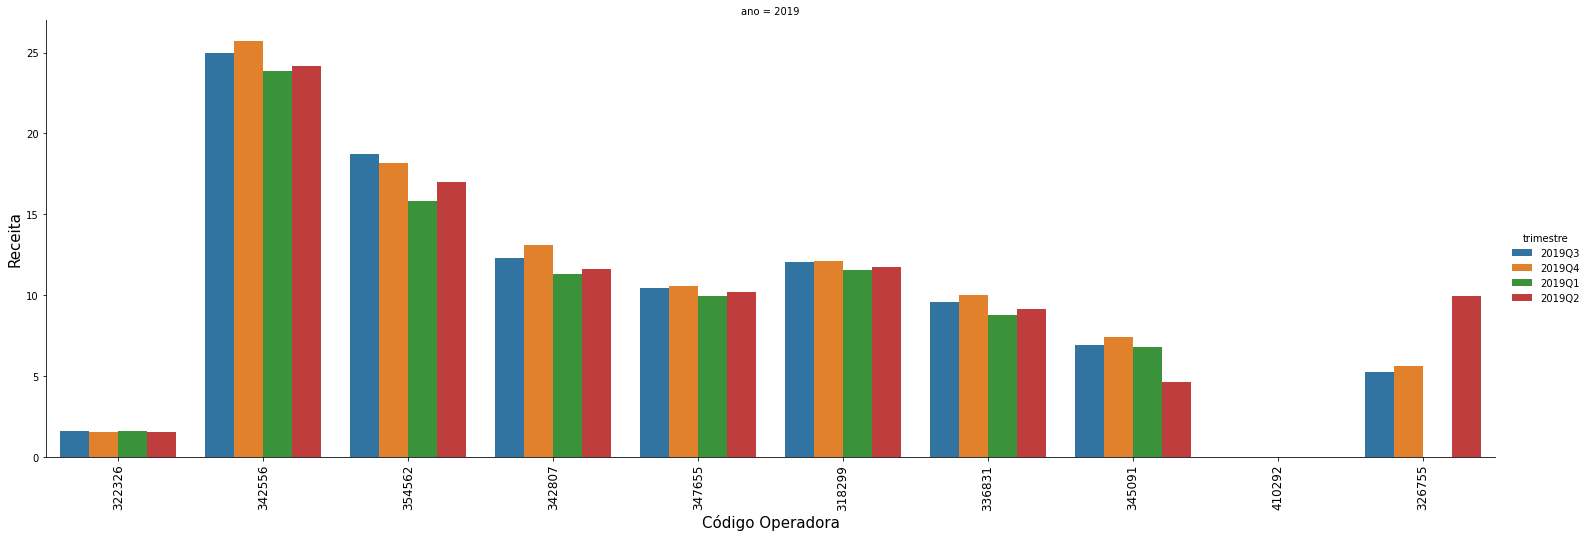

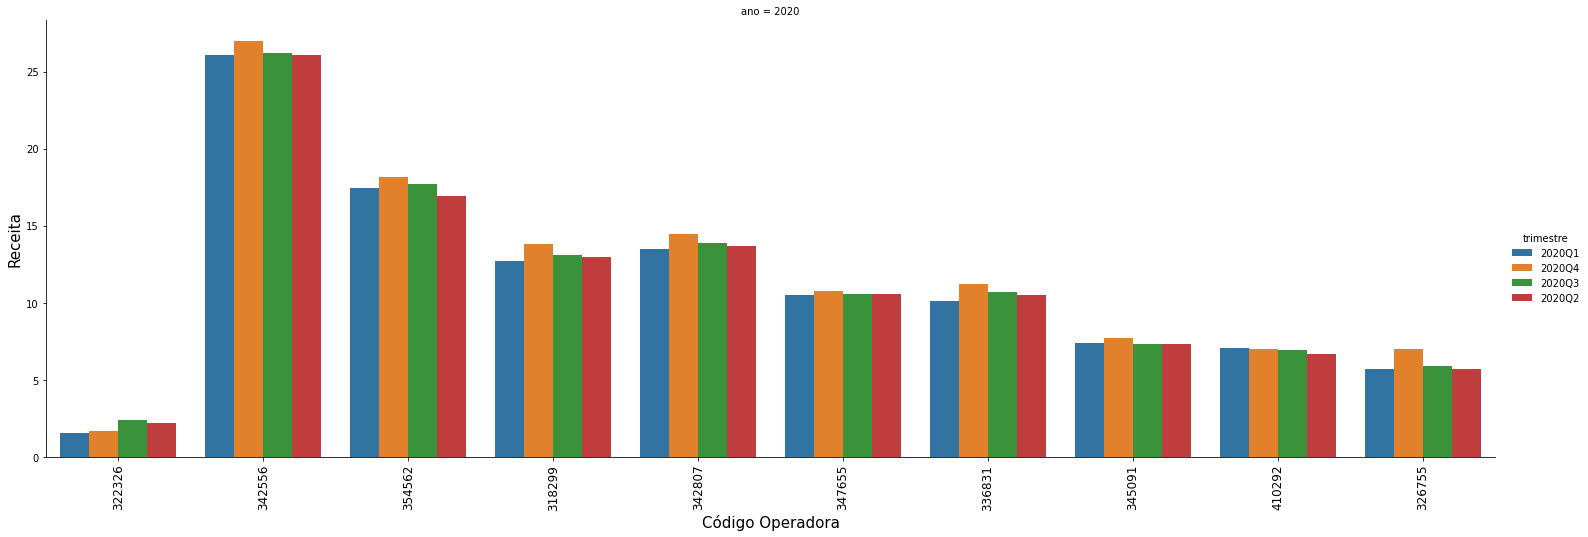

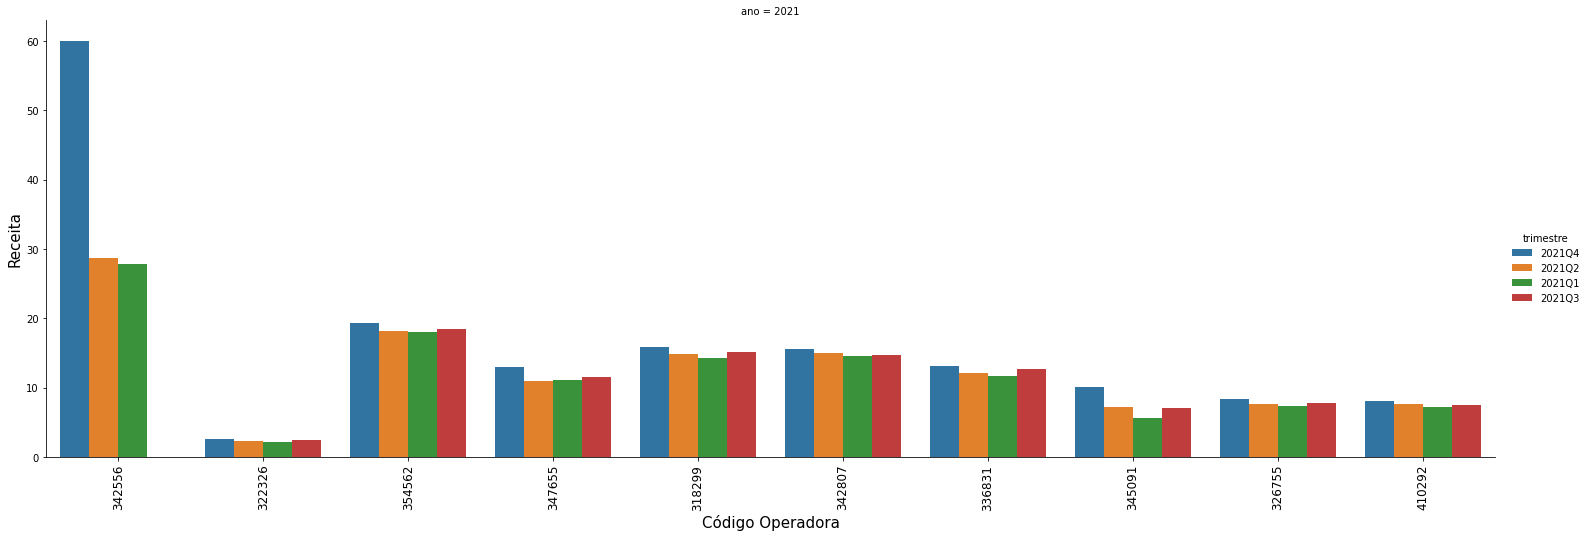

In [11]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

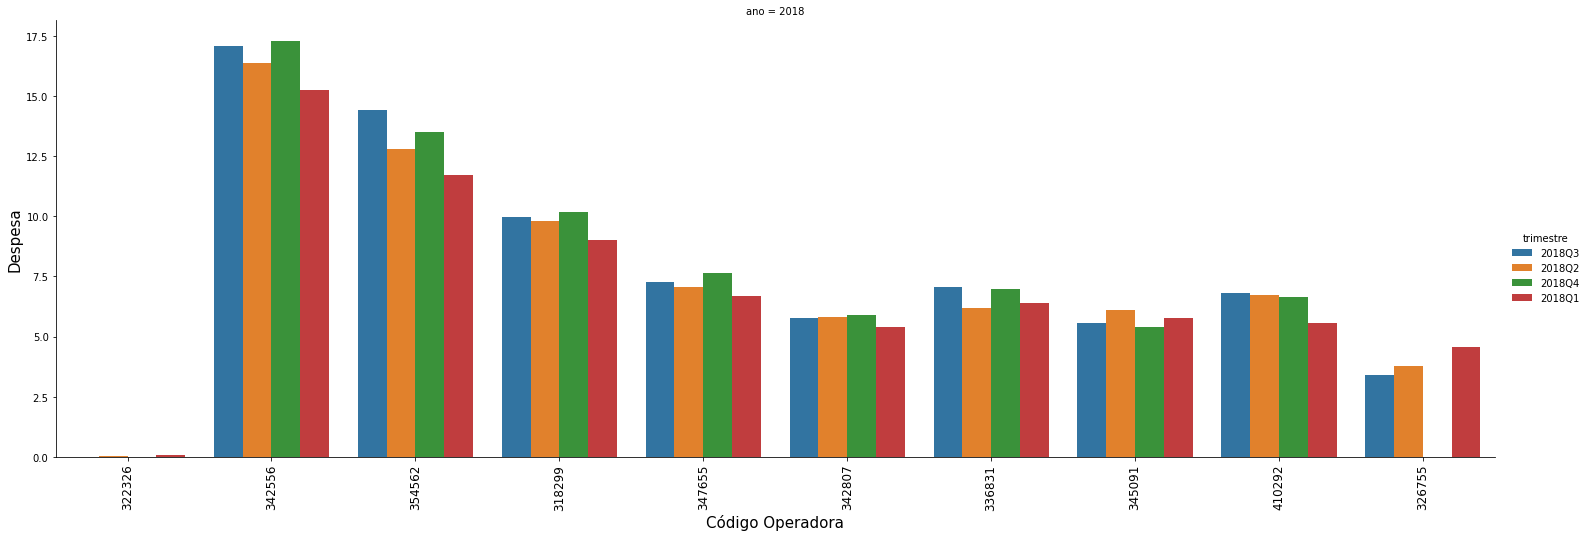

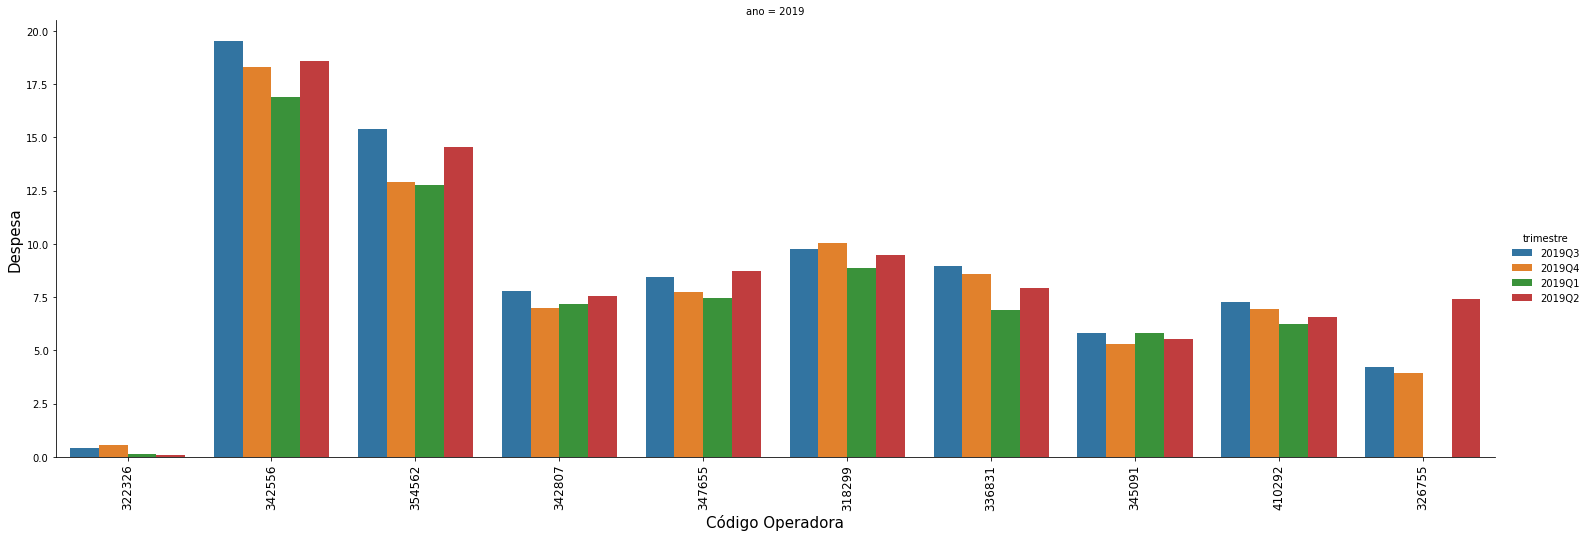

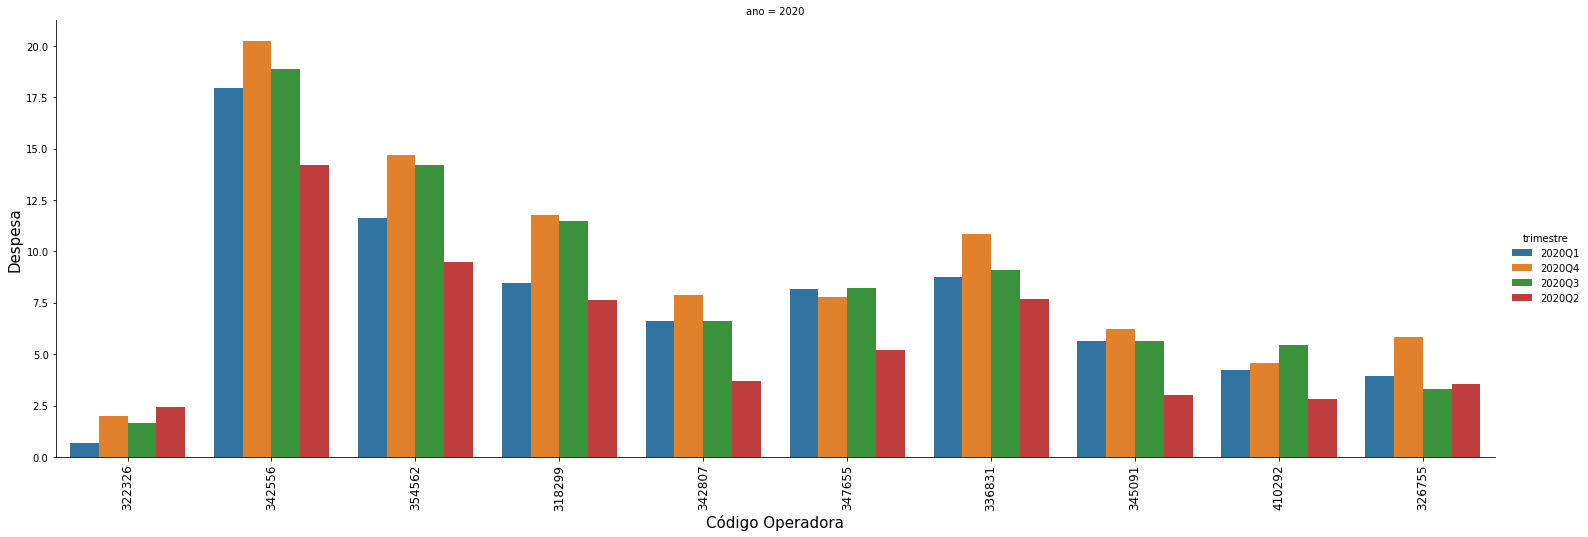

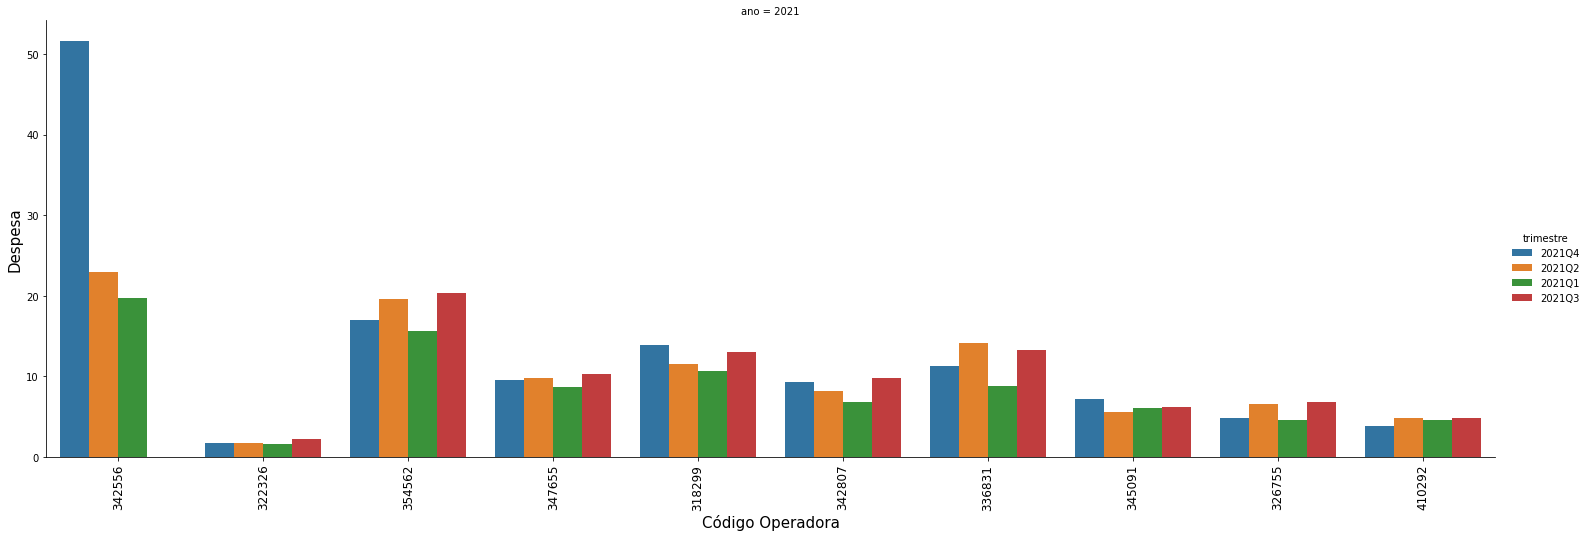

In [12]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Limpeza e Tratamento de Dados

In [13]:
ans_alterada1 = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':'sum',
                                                                                             'despesa':'sum'})

ans_alterada1 = ans_alterada1[(ans_alterada1['ano']>'2017') & (ans_alterada1['ano']<'2022')] #Filtra anos de 2018 até 2021

ans_alterada = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita != 0) & (ans_alterada1.despesa == 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa != 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa == 0)].index)

display(ans_alterada1.head())

,ano,cd_ops,trimestre,receita,despesa
0,2018,318299,2018Q1,11807016.350,8998580.520
1,2018,318299,2018Q2,12014084.300,9812864.570
2,2018,318299,2018Q3,10885884.590,9980503.250
3,2018,318299,2018Q4,11618926.400,10202574.800
4,2018,322326,2018Q1,1375827.720,67037.890


In [14]:
ans_alterada2 = ans_alterada1.groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))

display(ans_alterada2.head())

ans_alterada2.n_trimestre.unique()

,ano,cd_ops,n_trimestre
0,2018,318299,4
1,2018,322326,4
2,2018,326755,3
3,2018,336831,4
4,2018,342556,4


array([4, 3, 1], dtype=int64)

In [15]:
#Operadoras com lançamento contabeis em todos os trimestres do período selecionado para o estudo
ans_alterada_complete = ans_alterada2[ans_alterada2['n_trimestre']==4].reset_index(drop=True)
ans_alterada_complete = ans_alterada_complete[['ano','cd_ops']]
display(ans_alterada_complete.head())

complete_ops_list = ans_alterada_complete['cd_ops'].to_numpy()

,ano,cd_ops
0,2018,318299
1,2018,322326
2,2018,336831
3,2018,342556
4,2018,342807


In [16]:
#Operadoras com lançamento contabeis faltando em algum(uns) trimestre(s) do período selecionado para o estudo
ans_alterada_imcomplete = ans_alterada2[ans_alterada2['n_trimestre']!=4].reset_index(drop=True)
ans_alterada_imcomplete = ans_alterada_imcomplete[['ano','cd_ops']]
display(ans_alterada_imcomplete.head())

imcomplete_ops_list = ans_alterada_imcomplete['cd_ops'].to_numpy()

,ano,cd_ops
0,2018,326755
1,2018,410292
2,2019,326755
3,2021,342556


In [17]:
diff_list = np.setdiff1d(complete_ops_list,imcomplete_ops_list)

ans_alterada_complete = ans_alterada_complete[ans_alterada_complete["cd_ops"].isin(diff_list)]

ans_alterada_complete.head()

,ano,cd_ops
0,2018,318299
1,2018,322326
2,2018,336831
4,2018,342807
5,2018,345091


In [18]:
#Filtra as operadoras com lançamentos completos
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada3 =  ans_alterada1[i1.isin(i2)]

#diops_tcc_analise3[diops_tcc_analise3['receita']==0]

display(ans_alterada3.head())

#Verificação da filtragem
ans_alterada3_vef = ans_alterada3[(ans_alterada3['ano']>'2017') & (ans_alterada3['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada3_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,318299,2018Q1,11807016.350,8998580.520
1,2018,318299,2018Q2,12014084.300,9812864.570
2,2018,318299,2018Q3,10885884.590,9980503.250
3,2018,318299,2018Q4,11618926.400,10202574.800
4,2018,322326,2018Q1,1375827.720,67037.890


array([4], dtype=int64)

In [19]:
#Cálculo do percentual de crescimento entre os trimestres
ans_alterada3['ref1'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str))

ans_alterada3['ref2'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str)+
                            ans_alterada3['trimestre'].map(str))

ans_alterada3[['receita_shifted','despesa_shifted']] = ans_alterada3[['ref1','ref2','receita','despesa']].groupby(['ref1'])[['receita','despesa']].shift()

ans_alterada3['pct_tri_receita'] = ((ans_alterada3['receita'] / ans_alterada3['receita_shifted'])) 
ans_alterada3['pct_tri_despesa'] = ((ans_alterada3['despesa'] / ans_alterada3['despesa_shifted'])) 
 
ans_alterada3 = ans_alterada3[['ano','cd_ops','trimestre','receita','receita_shifted','pct_tri_receita','despesa','despesa_shifted','pct_tri_despesa']].fillna(0)

ans_alterada3.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa
0,2018,318299,2018Q1,11807016.350,0.000,0.000,8998580.520,0.000,0.000
1,2018,318299,2018Q2,12014084.300,11807016.350,1.018,9812864.570,8998580.520,1.090
2,2018,318299,2018Q3,10885884.590,12014084.300,0.906,9980503.250,9812864.570,1.017
3,2018,318299,2018Q4,11618926.400,10885884.590,1.067,10202574.800,9980503.250,1.022
4,2018,322326,2018Q1,1375827.720,0.000,0.000,67037.890,0.000,0.000


In [20]:
stats_ans_alterada = pd.DataFrame(ans_alterada3.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75]))

stats_ans_alterada = stats_ans_alterada.reset_index(level=[0,1])

stats_ans_alterada.columns = ['_'.join(col) for col in stats_ans_alterada.columns.values]

stats_ans_alterada = stats_ans_alterada[['ano_','trimestre_','pct_tri_receita_25%', 'pct_tri_receita_75%', 'pct_tri_despesa_25%', 'pct_tri_despesa_75%']]

stats_ans_alterada.rename(columns = {'ano_':'ano',
                                     'trimestre_':'trimestre',
                                     'pct_tri_receita_25%':'pct_tri_receita_25',
                                     'pct_tri_receita_75%':'pct_tri_receita_75',
                                     'pct_tri_despesa_25%':'pct_tri_despesa_25',
                                     'pct_tri_despesa_75%':'pct_tri_despesa_75'}, inplace = True)

stats_ans_alterada

,ano,trimestre,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,2018Q1,0.000,0.000,0.000,0.000
1,2018,2018Q2,1.021,1.079,1.009,1.083
2,2018,2018Q3,1.008,1.037,0.957,1.081
3,2018,2018Q4,1.038,1.059,0.951,1.019
4,2019,2019Q1,0.000,0.000,0.000,0.000
5,2019,2019Q2,0.993,1.034,1.003,1.140
6,2019,2019Q3,1.036,1.082,1.028,1.098
7,2019,2019Q4,0.987,1.055,0.905,0.992
8,2020,2020Q1,0.000,0.000,0.000,0.000
9,2020,2020Q2,0.996,1.029,0.596,0.889


In [21]:
ans_alterada4 =  pd.merge(ans_alterada3, stats_ans_alterada, how = 'left', on = ['ano','trimestre'])

#ans_alterada4 = ans_alterada4[( (ans_alterada4['pct_tri_receita'] >= ans_alterada4['pct_tri_receita_25']) & 
#                                (ans_alterada4['pct_tri_receita'] <= ans_alterada4['pct_tri_receita_75'])) &
#                                ((ans_alterada4['pct_tri_despesa'] >= ans_alterada4['pct_tri_despesa_25']) & 
#                                (ans_alterada4['pct_tri_despesa'] <= ans_alterada4['pct_tri_despesa_75']))]

ans_alterada4.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,318299,2018Q1,11807016.350,0.000,0.000,8998580.520,0.000,0.000,0.000,0.000,0.000,0.000
1,2018,318299,2018Q2,12014084.300,11807016.350,1.018,9812864.570,8998580.520,1.090,1.021,1.079,1.009,1.083
2,2018,318299,2018Q3,10885884.590,12014084.300,0.906,9980503.250,9812864.570,1.017,1.008,1.037,0.957,1.081
3,2018,318299,2018Q4,11618926.400,10885884.590,1.067,10202574.800,9980503.250,1.022,1.038,1.059,0.951,1.019
4,2018,322326,2018Q1,1375827.720,0.000,0.000,67037.890,0.000,0.000,0.000,0.000,0.000,0.000


In [22]:
stats_ans_alterada2 = ans_alterada4.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75])

stats_ans_alterada2 = stats_ans_alterada2.reset_index(level=[0,1])

stats_ans_alterada2.columns = ['_'.join(col) for col in stats_ans_alterada2.columns.values]

stats_ans_alterada2 = stats_ans_alterada2[['ano_','trimestre_','pct_tri_receita_50%', 'pct_tri_despesa_50%']]

stats_ans_alterada2.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_tri_receita_50%':'pct_tri_receita_50',
                                      'pct_tri_despesa_50%':'pct_tri_despesa_50'}, inplace = True)

stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,0.000,0.000
1,2018,2018Q2,1.059,1.058
2,2018,2018Q3,1.023,1.017
3,2018,2018Q4,1.045,0.984
4,2019,2019Q1,0.000,0.000
5,2019,2019Q2,1.022,1.067
6,2019,2019Q3,1.055,1.056
7,2019,2019Q4,1.012,0.918
8,2020,2020Q1,0.000,0.000
9,2020,2020Q2,1.014,0.816


In [23]:
stats_ans_alterada2 = stats_ans_alterada2.replace(0.0, 1.0)

stats_ans_alterada2[['pct_tri_receita_50_l1','pct_tri_despesa_50_l1']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50','pct_tri_despesa_50']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m1'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l1']

stats_ans_alterada2['pct_tri_despesa_50_m1'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l1']

stats_ans_alterada2[['pct_tri_receita_50_l2','pct_tri_despesa_50_l2']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50_m1','pct_tri_despesa_50_m1']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m2'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l2']

stats_ans_alterada2['pct_tri_despesa_50_m2'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l2']

stats_ans_alterada2 = stats_ans_alterada2[['ano','trimestre','pct_tri_receita_50_m2','pct_tri_despesa_50_m2']]

stats_ans_alterada2.rename(columns = {'pct_tri_receita_50_m2':'pct_tri_receita_50',
                                      'pct_tri_despesa_50_m2':'pct_tri_despesa_50'}, inplace = True)

stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,1.000,1.000
1,2018,2018Q2,1.059,1.058
2,2018,2018Q3,1.083,1.076
3,2018,2018Q4,1.132,1.058
4,2019,2019Q1,1.000,1.000
5,2019,2019Q2,1.022,1.067
6,2019,2019Q3,1.078,1.127
7,2019,2019Q4,1.091,1.035
8,2020,2020Q1,1.000,1.000
9,2020,2020Q2,1.014,0.816


In [24]:
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada5 =  ans_alterada1[~i1.isin(i2)]

#Retira as operadoras que so possuem lançamentos de receita ou despesa
ans_alterada5 = ans_alterada5[((ans_alterada5['receita']!=0.0)&(ans_alterada5['despesa']!=0.0))]

display(ans_alterada5.head())

ans_alterada5_vef = ans_alterada5[(ans_alterada5['ano']>'2017') & (ans_alterada5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada5_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
8,2018,326755,2018Q1,4907869.260,4568304.110
9,2018,326755,2018Q2,5023624.520,3788359.790
10,2018,326755,2018Q3,4733721.560,3397221.520
15,2018,342556,2018Q1,21203549.680,15241437.220
16,2018,342556,2018Q2,21710957.540,16363631.010


array([3, 4, 1], dtype=int64)

In [25]:
ans_alterada6 = ans_alterada5[['cd_ops','trimestre','receita','despesa']]
ans_alterada6 = ans_alterada6.set_index(['cd_ops','trimestre'])
mux = pd.MultiIndex.from_product([ans_alterada6.index.levels[0], ans_alterada6.index.levels[1]],names=['cd_ops','trimestre'])
ans_alterada6 = ans_alterada6.reindex(mux, fill_value=0).reset_index()

ans_alterada6['ano'] = ans_alterada6['trimestre'].dt.year

ans_alterada6['ano'] = ans_alterada6['ano'].apply(pd.Period, freq='A-DEC')

ans_alterada6 = ans_alterada6[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada6.sort_values(by=['ano','cd_ops'], ignore_index=True, inplace=True)

ans_alterada6.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,326755,2018Q1,4907869.260,4568304.110
1,2018,326755,2018Q2,5023624.520,3788359.790
2,2018,326755,2018Q3,4733721.560,3397221.520
3,2018,326755,2018Q4,0.000,0.000
4,2018,342556,2018Q1,21203549.680,15241437.220


In [26]:
ans_alterada7 = ans_alterada6.groupby(['ano','cd_ops'], as_index=False).agg({   'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada7['receita_tri'] = ans_alterada7['receita'] / 4.0

ans_alterada7['despesa_tri'] = ans_alterada7['despesa'] / 4.0

ans_alterada7.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,326755,14665215.340,11753885.420,3666303.835,2938471.355
1,2018,342556,89144629.750,65951678.680,22286157.438,16487919.670
2,2018,410292,61171.720,6715157.980,15292.930,1678789.495
3,2019,326755,20811851.060,15589694.360,5202962.765,3897423.590
4,2019,342556,98626567.330,73306713.010,24656641.832,18326678.253


In [27]:
ans_alterada8 =  pd.merge(ans_alterada6, ans_alterada7[['ano','cd_ops','receita_tri','despesa_tri']], how = 'outer', on = ['ano','cd_ops'])

ans_alterada8 = ans_alterada8[['ano','cd_ops','trimestre','receita_tri','despesa_tri']]

ans_alterada8.rename(columns = {'receita_tri':'receita', 'despesa_tri':'despesa'}, inplace = True)

ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita == 0) & (ans_alterada8.despesa == 0)].index)

ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita < 1.0) | (ans_alterada8.despesa < 1.0)].index)

#ans_alterada8[ans_alterada8['cd_ops']=='393321']

ans_alterada8.head()

#ans_alterada8_vef = ans_alterada8[(ans_alterada8['ano']>'2017') & (ans_alterada8['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#ans_alterada8_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,326755,2018Q1,3666303.835,2938471.355
1,2018,326755,2018Q2,3666303.835,2938471.355
2,2018,326755,2018Q3,3666303.835,2938471.355
3,2018,326755,2018Q4,3666303.835,2938471.355
4,2018,342556,2018Q1,22286157.438,16487919.670


In [28]:
ans_alterada9 = pd.merge(ans_alterada8,stats_ans_alterada2, on=['ano','trimestre'])

ans_alterada9['receita_m1'] = ans_alterada9['receita'] * ans_alterada9['pct_tri_receita_50']

ans_alterada9['despesa_m1'] = ans_alterada9['despesa'] * ans_alterada9['pct_tri_despesa_50']

ans_alterada9 = ans_alterada9[['ano','cd_ops','trimestre','receita_m1','despesa_m1']]

ans_alterada9.rename(columns = {'receita_m1':'receita', 'despesa_m1':'despesa'}, inplace = True)

#ans_alterada9[ans_alterada9['cd_ops']=='420077']
 
ans_alterada9.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,326755,2018Q1,3666303.835,2938471.355
1,2018,342556,2018Q1,22286157.438,16487919.670
2,2018,410292,2018Q1,15292.930,1678789.495
3,2018,326755,2018Q2,3882022.400,3108508.473
4,2018,342556,2018Q2,23597433.892,17442007.016


In [29]:
ans_alterada10 = ans_alterada9.groupby(['ano','cd_ops'], as_index=False).agg({  'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada10.rename(columns = {'receita':'receita2', 'despesa':'despesa2'}, inplace = True)

ans_alterada10 = pd.merge(ans_alterada10, ans_alterada7, on=['ano','cd_ops'])

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita','despesa','receita2','despesa2']]

ans_alterada10['receita_diff'] = ans_alterada10['receita2'] - ans_alterada10['receita']

ans_alterada10['despesa_diff'] = ans_alterada10['despesa2'] - ans_alterada10['despesa']

ans_alterada10['receita_tri_diff'] = ans_alterada10['receita_diff'] / 4.0

ans_alterada10['despesa_tri_diff'] = ans_alterada10['despesa_diff'] / 4.0

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita_tri_diff','despesa_tri_diff']]

ans_alterada10.head()

,ano,cd_ops,receita_tri_diff,despesa_tri_diff
0,2018,326755,251477.171,141210.479
1,2018,342556,1528640.306,792339.536
2,2018,410292,1048.965,80675.508
3,2019,326755,249576.524,222730.981
4,2019,342556,1182733.617,1047337.796


In [30]:
ans_alterada11 =  pd.merge(ans_alterada9, ans_alterada10, how = 'outer', on = ['ano','cd_ops'])

ans_alterada11['receita_final'] = ans_alterada11['receita'] - ans_alterada11['receita_tri_diff']

ans_alterada11['despesa_final'] = ans_alterada11['despesa'] - ans_alterada11['despesa_tri_diff']

ans_alterada11 = ans_alterada11[['ano','cd_ops','trimestre','receita_final','despesa_final']]

ans_alterada11.rename(columns = {'receita_final':'receita', 'despesa_final':'despesa'}, inplace = True)

ans_alterada11.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,326755,2018Q1,3414826.664,2797260.876
1,2018,326755,2018Q2,3630545.229,2967297.994
2,2018,326755,2018Q3,3720080.861,3020402.391
3,2018,326755,2018Q4,3899762.585,2968924.159
4,2018,342556,2018Q1,20757517.131,15695580.134


In [31]:
ans_alterada12 = ans_alterada11.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada12['receita_tri'] = ans_alterada12['receita'] / 4.0

ans_alterada12['despesa_tri'] = ans_alterada12['despesa'] / 4.0

ans_alterada12.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,326755,14665215.340,11753885.420,3666303.835,2938471.355
1,2018,342556,89144629.750,65951678.680,22286157.438,16487919.670
2,2018,410292,61171.720,6715157.980,15292.930,1678789.495
3,2019,326755,20811851.060,15589694.360,5202962.765,3897423.590
4,2019,342556,98626567.330,73306713.010,24656641.832,18326678.253


In [32]:
ans_alterada13 = ans_alterada3[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada14 = pd.concat([ans_alterada13, ans_alterada11], ignore_index=True)

#ans_alterada14[ans_alterada14['cd_ops']=='317233']

ans_alterada14.head()

#diops_tcc_analise_vef = diops_tcc_analise14[(diops_tcc_analise14['ano']>'2017') & (diops_tcc_analise14['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,318299,2018Q1,11807016.350,8998580.520
1,2018,318299,2018Q2,12014084.300,9812864.570
2,2018,318299,2018Q3,10885884.590,9980503.250
3,2018,318299,2018Q4,11618926.400,10202574.800
4,2018,322326,2018Q1,1375827.720,67037.890


In [33]:
ans_alterada15 = ans_alterada14.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                                    'despesa':lambda x: sum_million(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada15['pct_despesa'] = ans_alterada15.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada15.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada15 = ans_alterada15[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada15.set_index('trimestre', inplace=True)

ans_alterada15

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,84.940,65.130,10,76.680
2018Q2,89.470,69.090,10,77.220
2018Q3,90.840,71.830,10,79.070
2018Q4,94.900,70.880,10,74.690
2019Q1,94.220,70.160,9,74.460
2019Q2,94.970,76.290,9,80.330
2019Q3,102.450,80.410,9,78.490
2019Q4,104.120,73.840,9,70.920
2020Q1,111.520,73.610,10,66.010


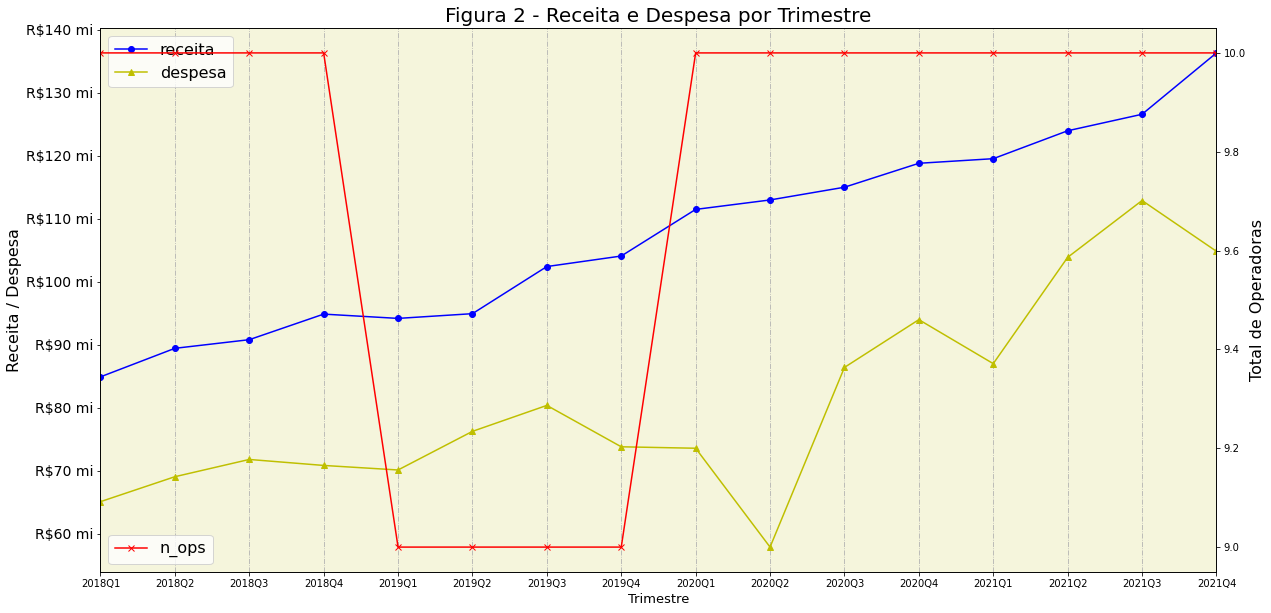

In [34]:
df_plot = ans_alterada15.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('emp_m_filan_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [35]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada16.head()

,ano,cd_ops,receita,despesa
4,2018,342556,89.140,65.950
8,2018,354562,63.320,52.450
0,2018,318299,46.330,38.990
5,2018,342807,40.730,22.850
7,2018,347655,38.830,28.660


In [36]:
ans_alterada_ops = ans_alterada16.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada14.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada16 =  ans_alterada14[i1.isin(i2)]

ans_alterada16.sort_values(by=['receita'], ascending=False, inplace=True)

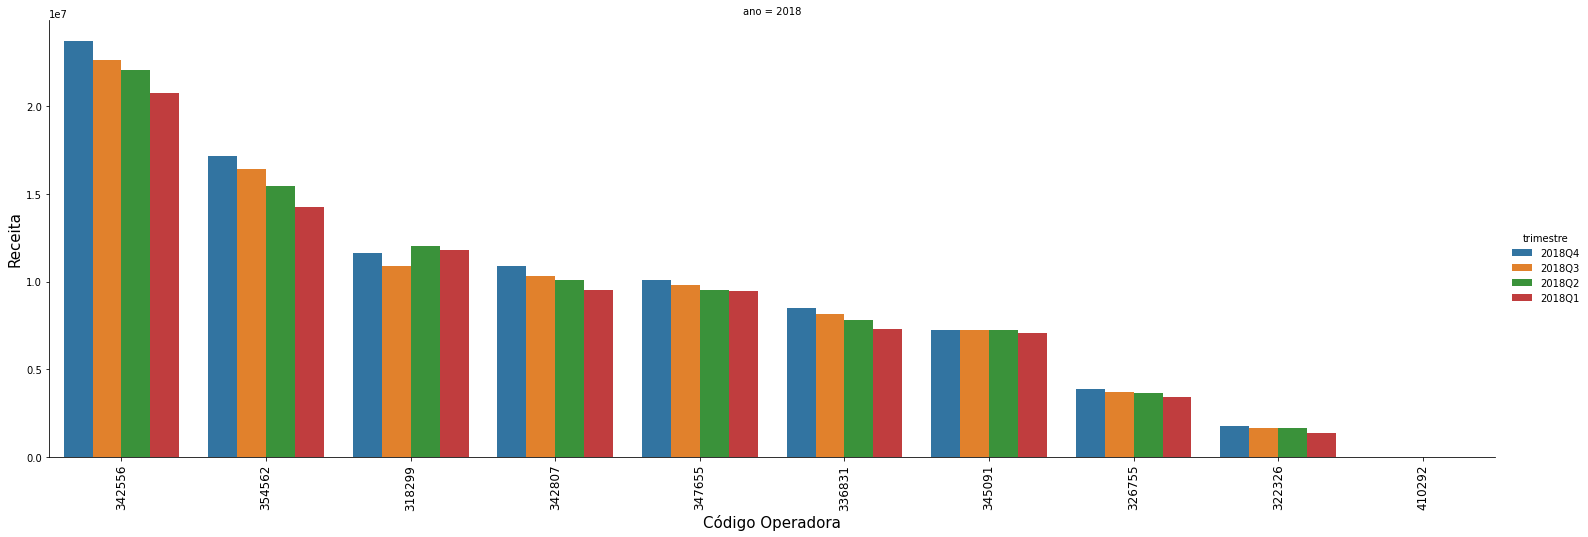

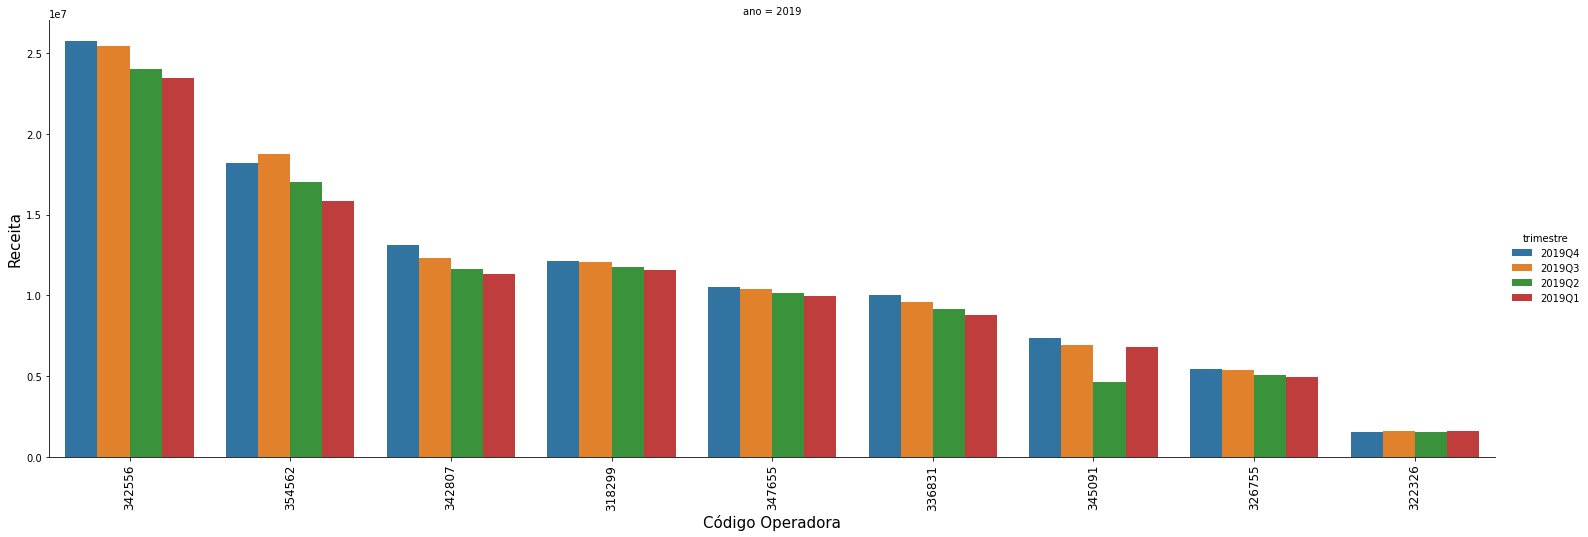

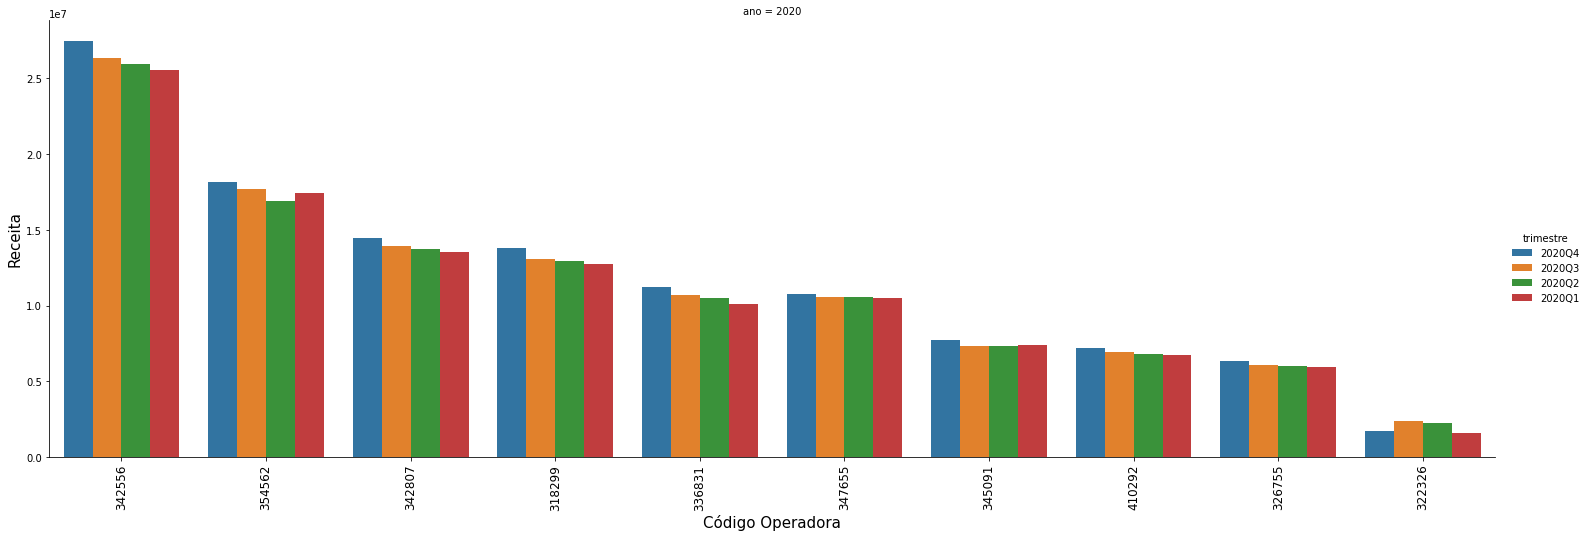

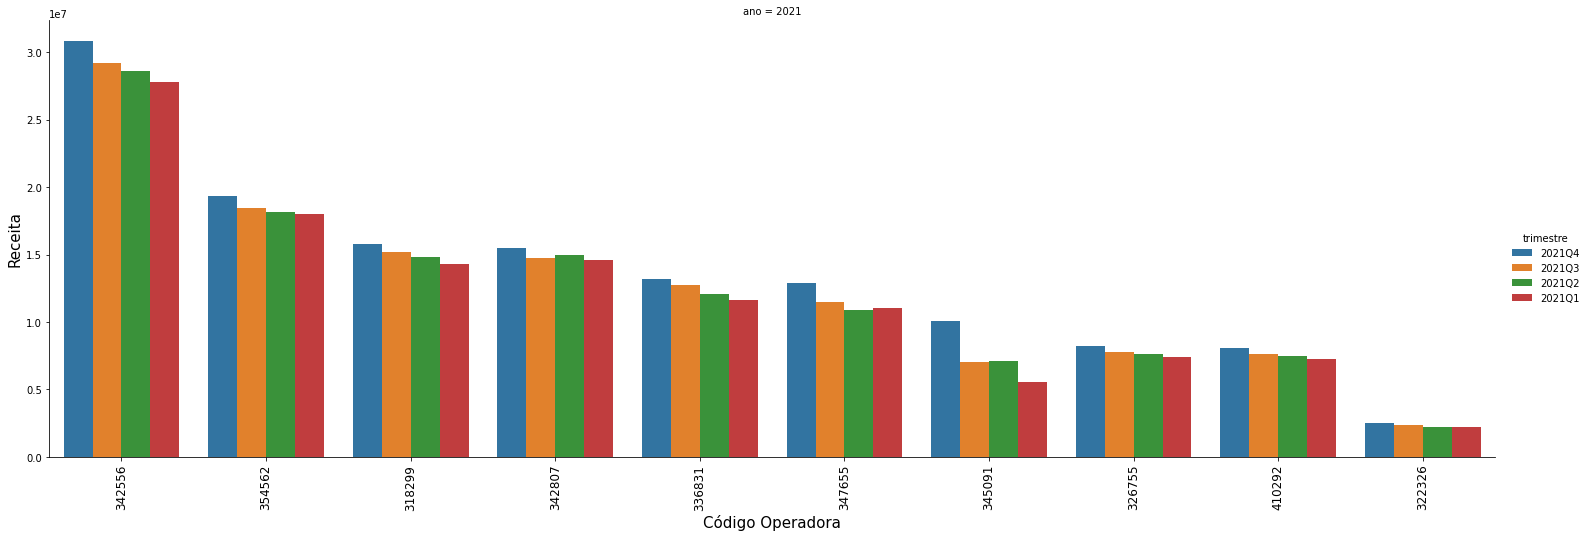

In [37]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

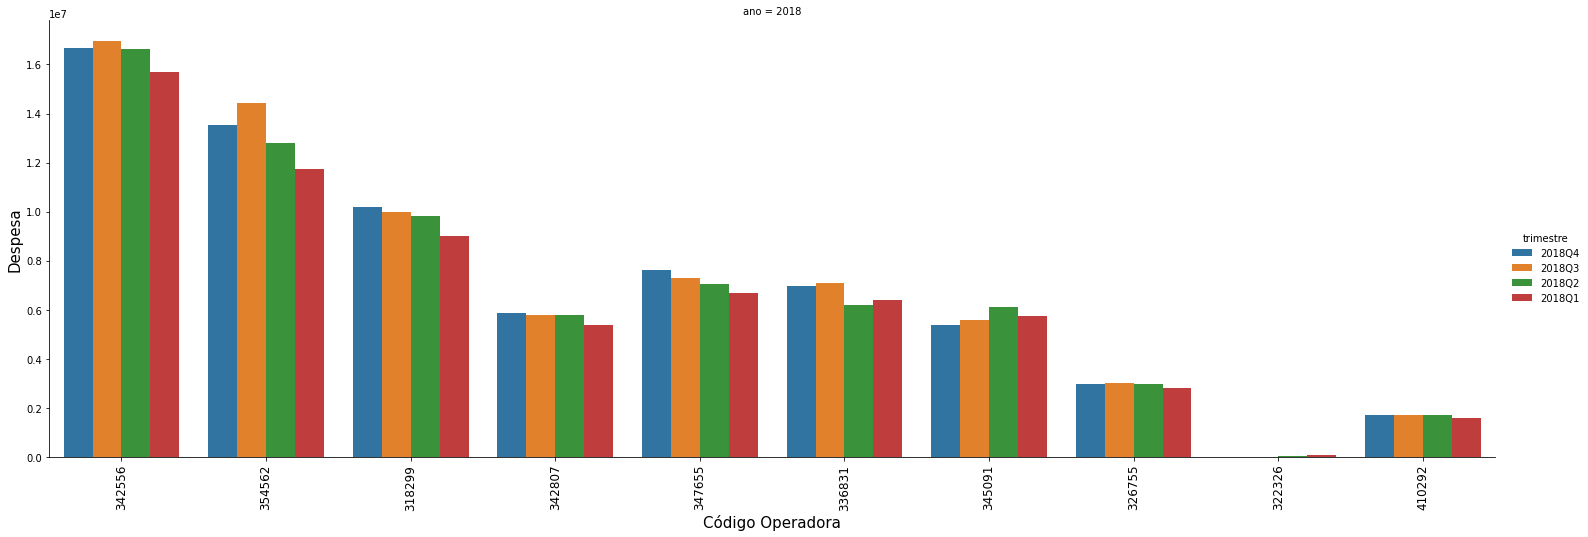

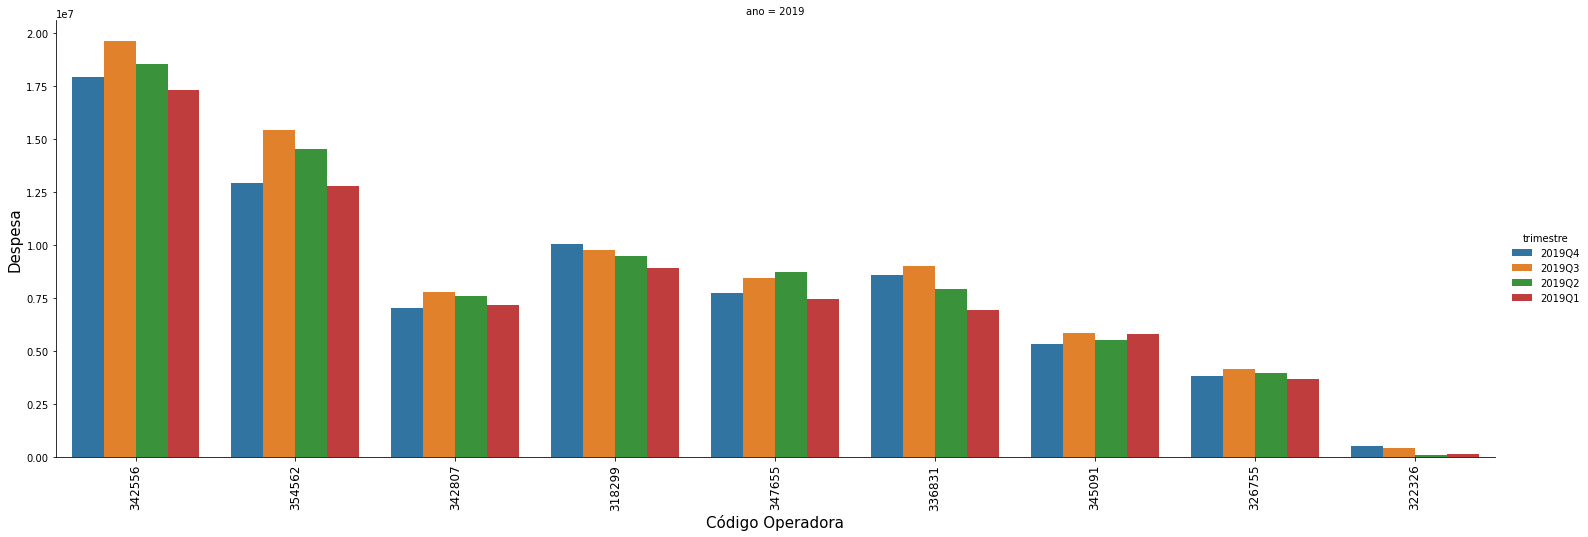

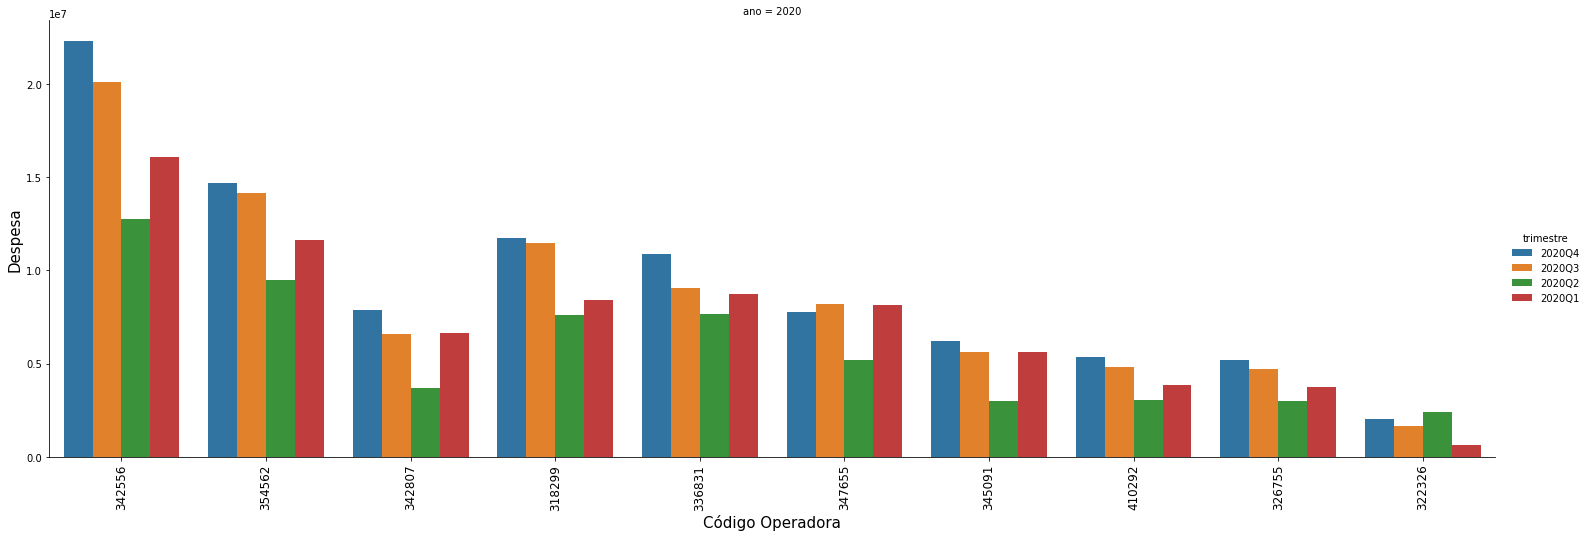

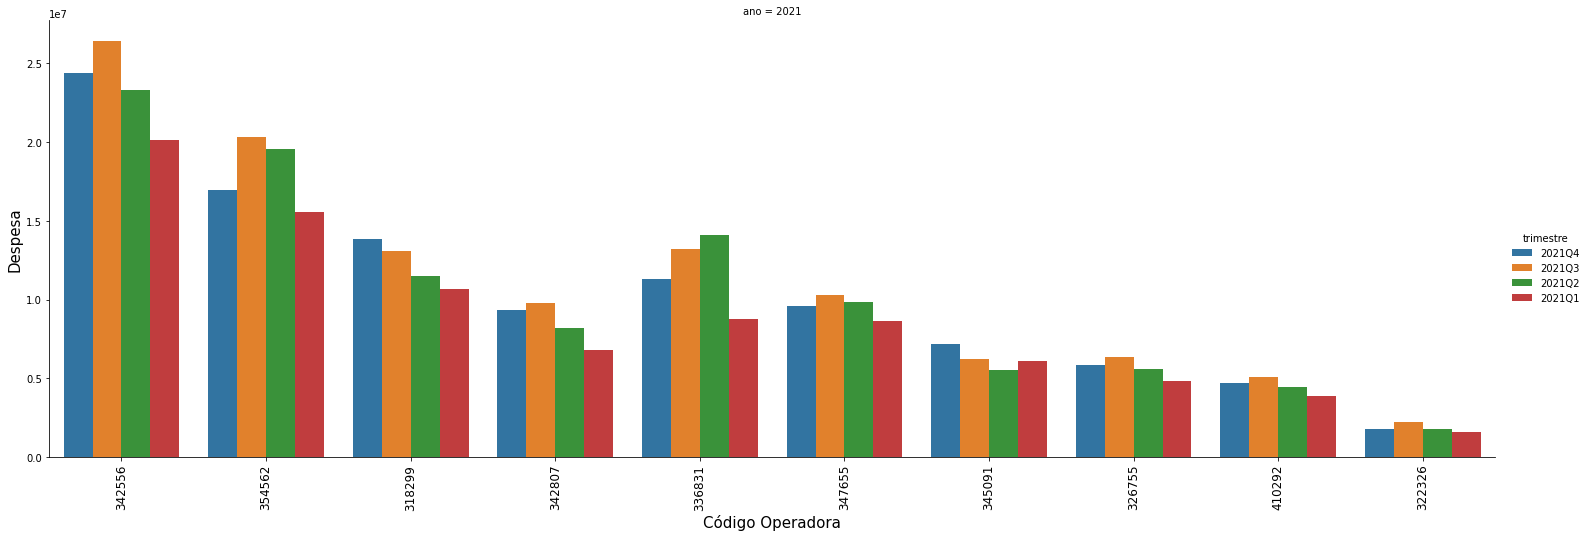

In [38]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

In [39]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\TCC\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib

,cd_ops,modalidade,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,benef
146900,27,Médico-hospitalar,A,Individual,Não identificado,2017-09-01,2017,2017Q3,4
228965,27,Médico-hospitalar,A,Individual,Não identificado,2017-10-01,2017,2017Q4,4
332456,27,Médico-hospitalar,A,Individual,Não identificado,2017-11-01,2017,2017Q4,4
332180,27,Médico-hospitalar,A,Individual,Não identificado,2017-12-01,2017,2017Q4,4
33924,27,Médico-hospitalar,A,Individual,Não identificado,2018-01-01,2018,2018Q1,4
...,...,...,...,...,...,...,...,...,...
390516,422975,Odontológico,P,Adesao,Pre-estabelecido,2022-03-01,2022,2022Q1,137
137641,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-01-01,2022,2022Q1,92
250037,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-02-01,2022,2022Q1,99
29707,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-03-01,2022,2022Q1,115


In [40]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

,cd_ops,benef,port_ops
0,477,115244,Grande
1,515,33402,Médio
2,582,990798,Grande
3,701,614431,Grande
4,884,8336,Pequeno


In [41]:
filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['financiamento'] != 'Não identificado'
filtro3 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','vigencia','contratacao', 'financiamento', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.replace('Pós-estabelecido','Pos-estabelecido', inplace=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7
106447,2022,422835,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,14


In [42]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['ano','cd_ops','contratacao','id_calendar','trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef', 'benefm', 'n_meses', 'mes']]

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef,benefm,n_meses,mes
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173,11173.000,1,9
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909,10909.000,3,10
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754,10831.500,3,11
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584,10749.000,3,12
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237,17237.000,1,9
...,...,...,...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188,143.000,2,3
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3,3.000,4,1
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7,5.000,4,2
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646,218.667,4,3


In [43]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes','benefm','n_meses'], axis='columns', inplace=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef']]

sib_filtrada['ano'] =  pd.to_datetime(sib_filtrada['ano'], format='%Y')

sib_filtrada['ano'] = sib_filtrada['ano'].dt.to_period('Y')

sib_filtrada['cd_ops'] = sib_filtrada['cd_ops'].astype('str')

sib_filtrada = sib_filtrada[(sib_filtrada['contratacao'] == tipo_contratacao)].reset_index(drop=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','trimestre','benef']]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','trimestre'],as_index=False).agg({'benef':'sum'})

sib_filtrada

,ano,cd_ops,trimestre,benef
0,2017,27,2017Q3,17237
1,2017,27,2017Q4,17190
2,2017,300012,2017Q3,7879
3,2017,300012,2017Q4,7856
4,2017,300136,2017Q3,25346
...,...,...,...,...
11996,2022,515,2022Q1,33402
11997,2022,5711,2022Q1,2840873
11998,2022,582,2022Q1,358720
11999,2022,6246,2022Q1,1633509


In [44]:
ans_alterada25 = pd.merge(ans_alterada14,sib_filtrada, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25['modalidade'] = tipo_modalidade

ans_alterada25['port_ops'] = porte_operadora

ans_alterada25['contratacao'] = tipo_contratacao

ans_alterada25.to_csv('emp_m_filan.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2018,318299,2018Q1,11807016.350,8998580.520,23691
1,2018,318299,2018Q2,12014084.300,9812864.570,23624
2,2018,318299,2018Q3,10885884.590,9980503.250,22570
3,2018,318299,2018Q4,11618926.400,10202574.800,22615
4,2018,322326,2018Q1,1375827.720,67037.890,40164


In [45]:
ans_alterada26 = ans_alterada25.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                                    'despesa':lambda x: sum_million(x),
                                                                                    'benef': 'sum',
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada26['pct_despesa'] = ans_alterada26.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada26.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_alterada26 = ans_alterada26[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_alterada26.to_csv('emp_m_filan_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada26.set_index('trimestre', inplace=True)

ans_alterada26 

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,84.940,65.130,228631,10,76.680
2018Q2,89.470,69.090,230336,10,77.220
2018Q3,90.840,71.830,231756,10,79.070
2018Q4,94.900,70.880,233583,10,74.690
2019Q1,94.220,70.160,220646,9,74.460
2019Q2,94.970,76.290,221129,9,80.330
2019Q3,102.450,80.410,224464,9,78.490
2019Q4,104.120,73.840,225787,9,70.920
2020Q1,111.520,73.610,241946,10,66.010


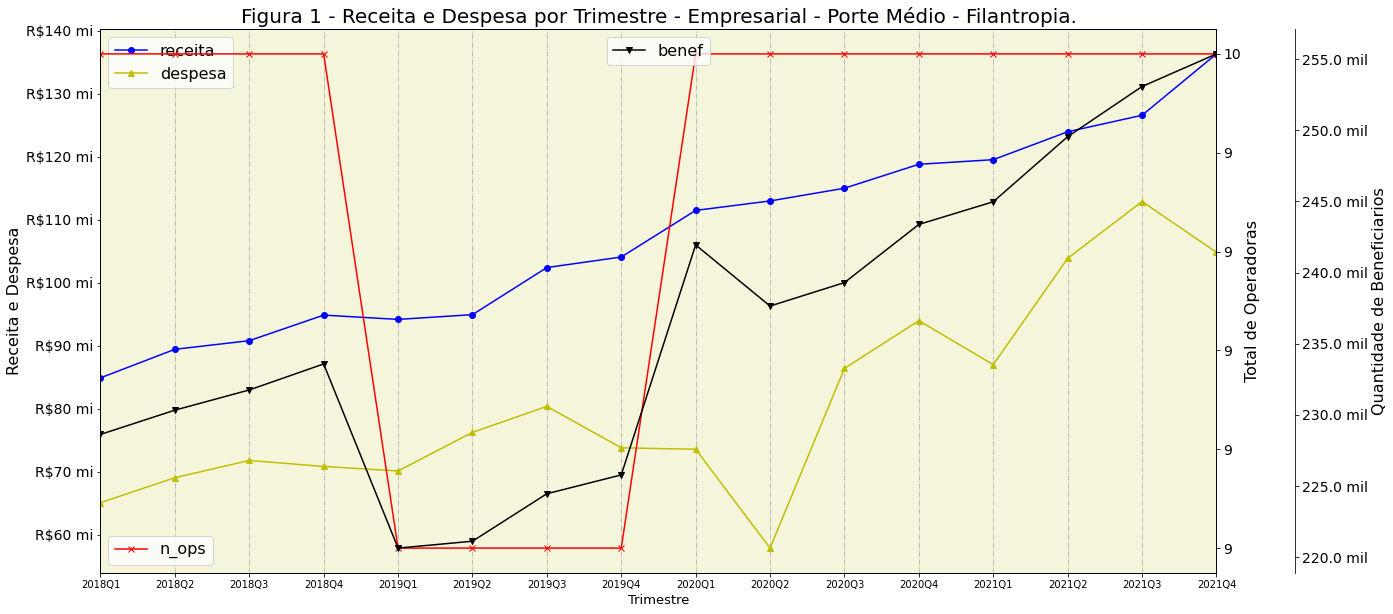

In [46]:
df_plot = ans_alterada26.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Empresarial - Porte Médio - Filantropia.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mil'.format(x/1e3) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.savefig('ade_m_filan_02.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [47]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada27 = ans_alterada25.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada27.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada27.head()

,ano,cd_ops,receita,despesa
4,2018,342556,89.140,65.950
8,2018,354562,63.320,52.450
0,2018,318299,46.330,38.990
5,2018,342807,40.730,22.850
7,2018,347655,38.830,28.660


In [48]:
ans_alterada_ops = ans_alterada27.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada25.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada28 =  ans_alterada25[i1.isin(i2)]

ans_alterada28.sort_values(by=['receita'], ascending=False, inplace=True)

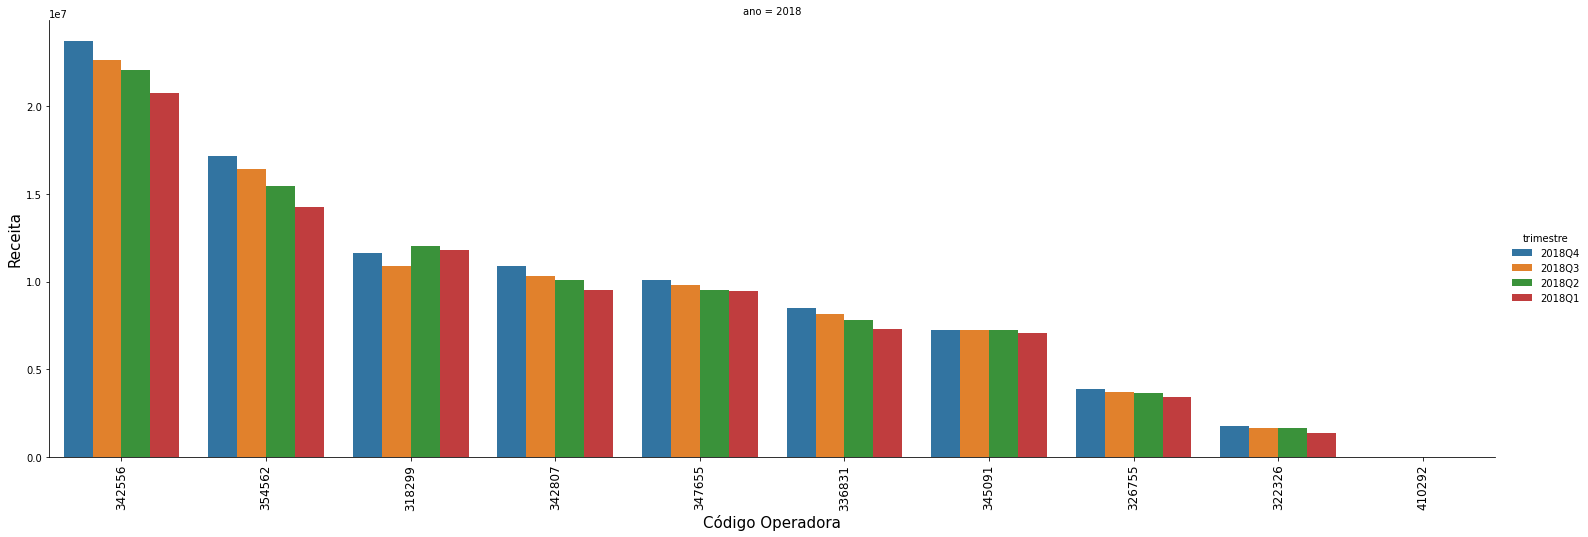

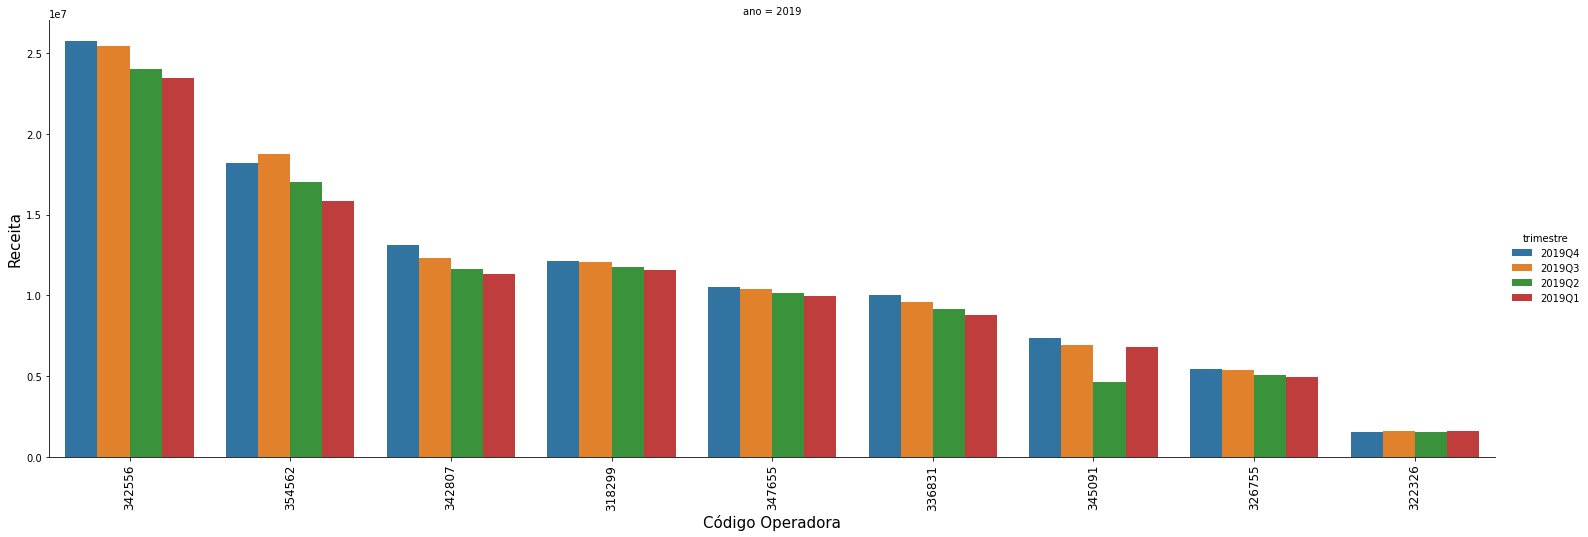

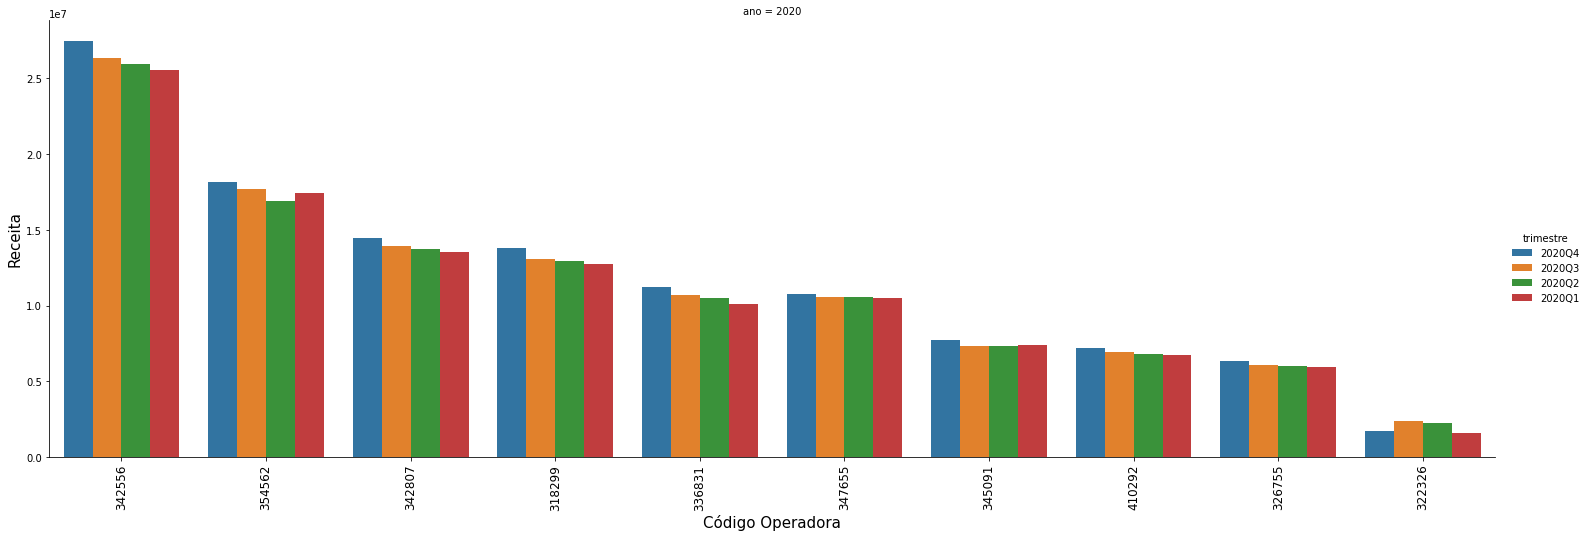

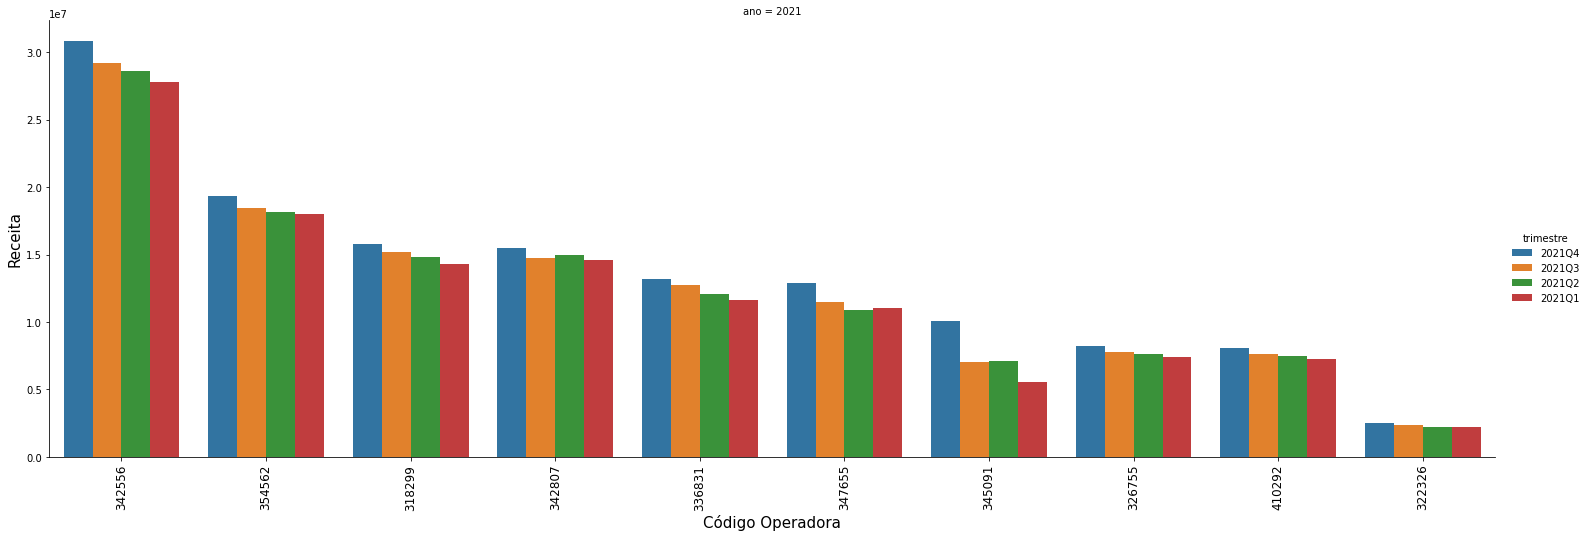

In [49]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

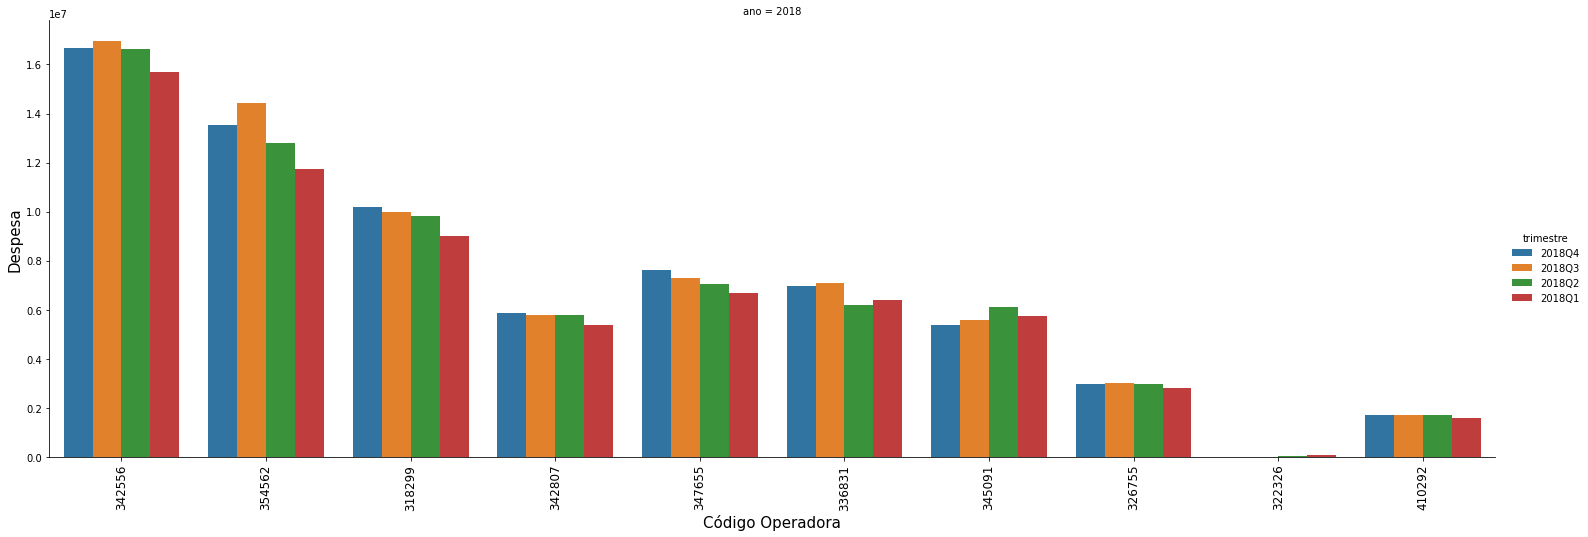

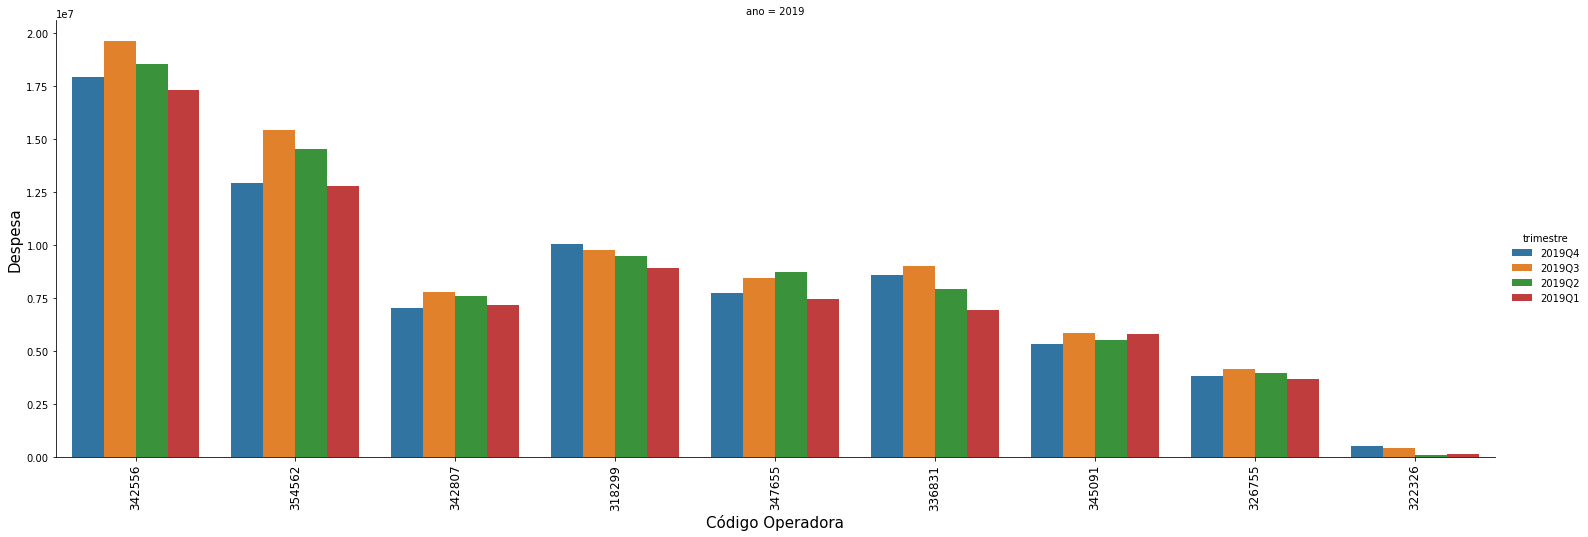

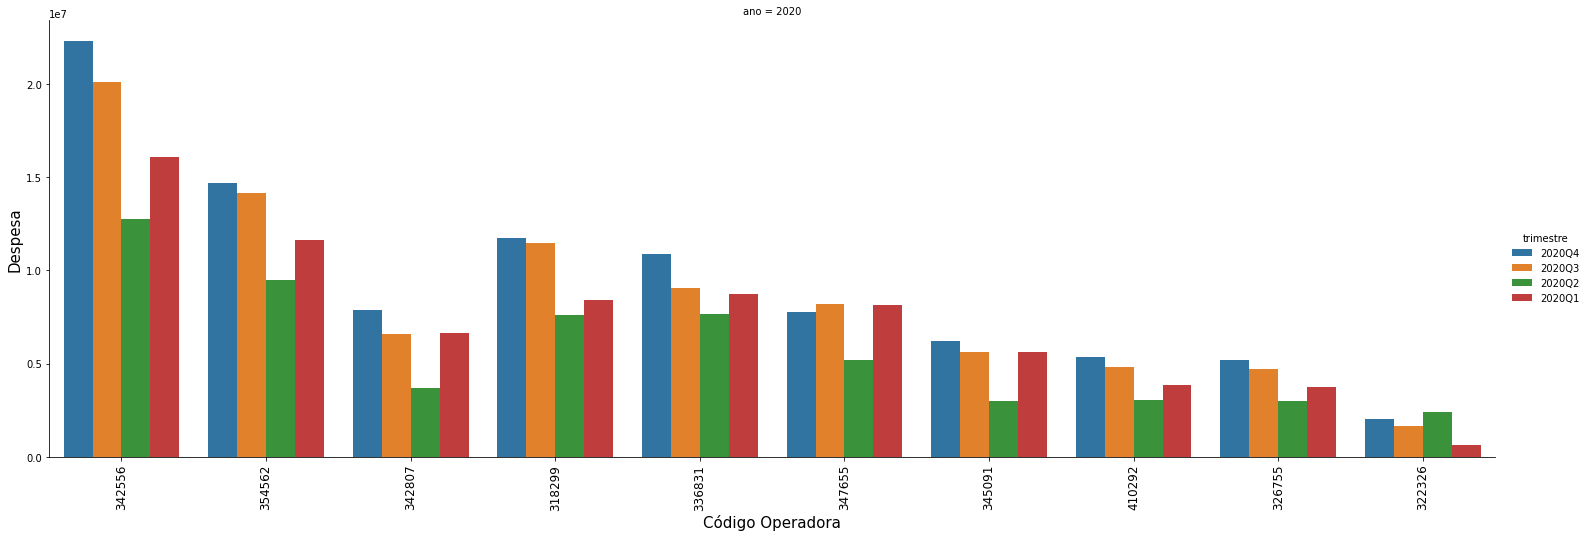

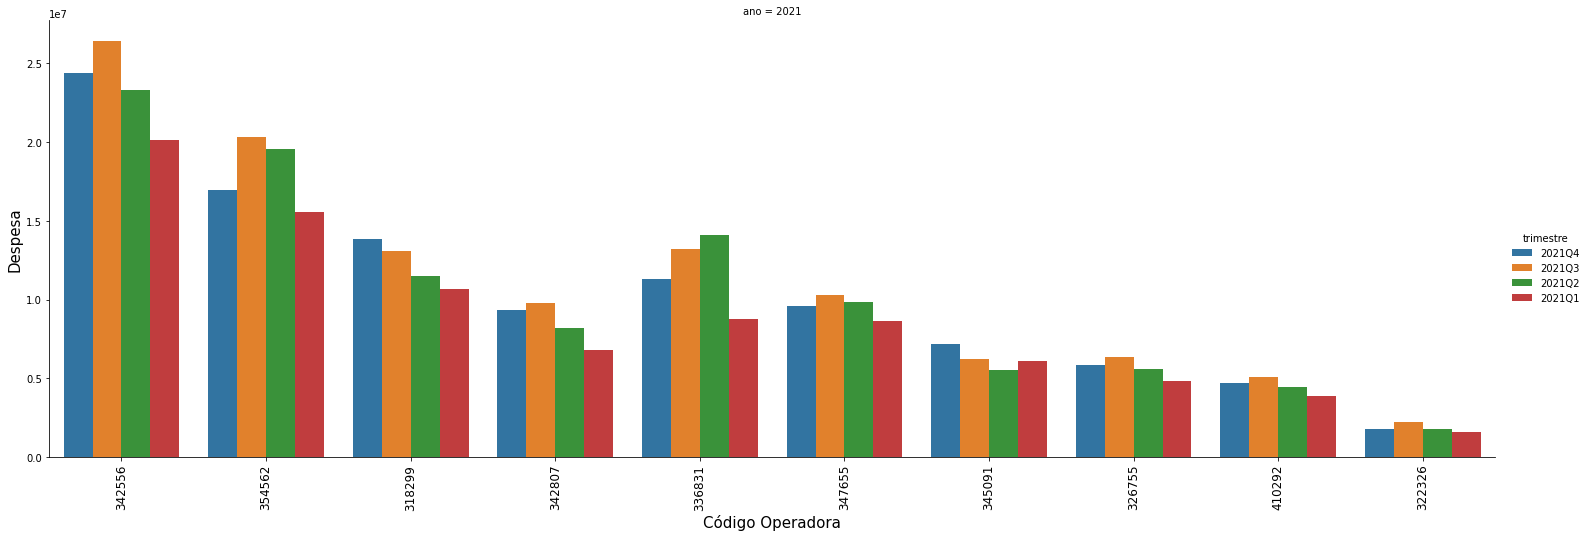

In [50]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot